# Risk Comparsion

1. Get rankings of risk prediction scores from PCE and DDH
2. Look at their relative positions 
3. See how many of them are reclassified. 

## Project PCE thresholds DDH Risks

In [206]:
import pandas as pd

In [214]:
ddh_risk_df = pd.read_csv('/Users/excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/Dynamic-DeepHit LRPP/DDH_pred_df.csv')

In [215]:
# clean up extra obs
pce_exclude = pd.read_csv('PCE_excluded.csv')
ddh_risk_df = ddh_risk_df.loc[~ddh_risk_df['pt_id'].isin(pce_exclude['index']),]
ddh_risk_df = ddh_risk_df.reset_index().reset_index().drop(columns = ['index'])
ddh_risk_df['pt_id'] = ddh_risk_df['level_0']

In [216]:
ddh_risk_df['risk_category'] = 'low'
ddh_risk_df.loc[(ddh_risk_df['value'] >= 0.05) & (ddh_risk_df['value'] < 0.075), 'risk_category'] = 'borderline'
ddh_risk_df.loc[(ddh_risk_df['value'] >= 0.075) & (ddh_risk_df['value'] < 0.2), 'risk_category'] = 'intermediate'
ddh_risk_df.loc[(ddh_risk_df['value'] >= 0.20), 'risk_category'] = 'high'

In [217]:
ddh_risk_df.risk_category.value_counts()/len(ddh_risk_df)

intermediate    0.465273
low             0.372669
borderline      0.162058
Name: risk_category, dtype: float64

<AxesSubplot:>

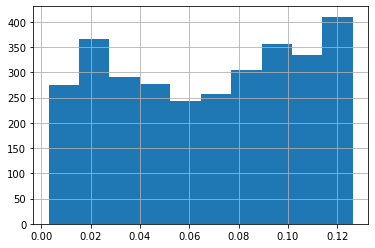

In [218]:
ddh_risk_df.value.hist()

In [219]:
ddh_risk_df

,level_0,pt_id,pred_time,eval_time,value,risk_category
0,0,0,1,0,0.017411,low
1,1,1,1,0,0.072617,borderline
2,2,2,1,0,0.057481,borderline
3,3,3,1,0,0.014913,low
4,4,4,1,0,0.109962,intermediate
...,...,...,...,...,...,...
3105,3105,3105,1,0,0.020543,low
3106,3106,3106,1,0,0.035277,low
3107,3107,3107,1,0,0.017955,low
3108,3108,3108,1,0,0.045019,low


## Ranking Comparison

In [220]:
pce_pred_df = pd.read_csv('/Users/excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/Dynamic-DeepHit LRPP/AUC + Risk Calculations/pce_pred_df.csv')

In [221]:
pce_pred_df_order = pce_pred_df.loc[:,['risk', 'risk_cat', 'true_label']].sort_values('risk').reset_index().rename(columns = {'index': 'id'}).reset_index().rename(columns = {'index': 'risk_order_pce'})

In [222]:
ddh_risk_df = ddh_risk_df.loc[ddh_risk_df.pt_id.isin(pce_pred_df_order['id']),]
ddh_risk_df_order = ddh_risk_df.loc[:,['value', 'risk_category']].sort_values('value').reset_index().rename(columns = {'index': 'id'}).reset_index().rename(columns = {'index': 'risk_order_ddh'})

In [223]:
pce_pred_df_order = pce_pred_df_order.rename(columns = {'risk_cat' : 'risk_cat_pce'})
ddh_risk_df_order = ddh_risk_df_order.rename(columns = {'risk_category' : 'risk_cat_ddh'})

In [224]:
risk_df_order = pd.merge(pce_pred_df_order, ddh_risk_df_order)

In [225]:
risk_df_order.to_csv('risk_df_order.csv', index = False)

## Race & Sex Category Comparison
Race Category:
1. White 
2. Black 

Sex Category:
1. Male
2. Female

In [226]:
df = pd.read_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/LRPP data/LRPP_select.csv')
indecies_test = pd.read_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/LRPP data/random_index_select.csv')
indecies_test.columns = ['index', 'label', 'study_index']
indecies_test = indecies_test.loc[indecies_test['study_index'] == True, :]
df = df.loc[df['id'].isin(indecies_test['index']), :]
# filter out patients without data before 8 years
max_age_before_threshold = df.loc[df['times'] <= 8, :].groupby('id').times.max().reset_index()
df = df.loc[df['id'].isin(max_age_before_threshold['id']), :]

# gender 
df = df[['id', 'race', 'gender']].drop_duplicates().reset_index().reset_index().drop(columns=('index'))
df['id'] = df['level_0']

# merge datasets 
risk_demo = pd.merge(risk_df_order, df[['id', 'race', 'gender']]) 

In [227]:
from sklearn.metrics import roc_auc_score

In [228]:
risk_demo.head()

,risk_order_pce,id,risk,risk_cat_pce,true_label,risk_order_ddh,value,risk_cat_ddh,race,gender
0,0,2129,0.001,Low Risk,0,132,0.010692,low,2,2
1,1,2406,0.001,Low Risk,0,37,0.006730,low,1,2
2,2,1787,0.001,Low Risk,0,25,0.006030,low,2,2
3,3,3019,0.001,Low Risk,0,18,0.005684,low,1,2
4,4,2160,0.001,Low Risk,0,73,0.008648,low,2,2


### Race

In [229]:
risk_demo_white = risk_demo.loc[risk_demo['race'] == 1, :]
print('PCE AUC White:', roc_auc_score(risk_demo_white['true_label'], risk_demo_white['risk']))
print('DDH AUC White:', roc_auc_score(risk_demo_white['true_label'], risk_demo_white['value']))

PCE AUC White: 0.7719682179818207
DDH AUC White: 0.793159728782249


In [230]:
risk_demo_black = risk_demo.loc[risk_demo['race'] == 2, :]
print('PCE AUC Black:', roc_auc_score(risk_demo_black['true_label'], risk_demo_black['risk']))
print('DDH AUC Black:', roc_auc_score(risk_demo_black['true_label'], risk_demo_black['value']))

PCE AUC Black: 0.7910150517797996
DDH AUC Black: 0.8055741897614356


### Sex

In [231]:
risk_demo_males = risk_demo.loc[risk_demo['gender'] == 1, :]
print('PCE AUC Males:', roc_auc_score(risk_demo_males['true_label'], risk_demo_males['risk']))
print('DDH AUC Males:', roc_auc_score(risk_demo_males['true_label'], risk_demo_males['value']))

PCE AUC Males: 0.7549475094929641
DDH AUC Males: 0.7684195411468138


In [232]:
risk_demo_females = risk_demo.loc[risk_demo['gender'] == 2, :]
print('PCE AUC Females:', roc_auc_score(risk_demo_females['true_label'], risk_demo_females['risk']))
print('DDH AUC Females:', roc_auc_score(risk_demo_females['true_label'], risk_demo_females['value']))

PCE AUC Females: 0.7792000333667
DDH AUC Females: 0.8039247580914247


---------------------
# Graveyard






## Risk Comparison
1. Scale risk scores to mean 

In [ ]:
len(pce_pred_df)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

risk_df = pd.concat([ddh_risk_df['value'], pce_pred_df['risk']], axis = 1)
risk_df.columns = ['ddh_risk', 'pce_risk']

scaler = MinMaxScaler()
risk_df_scale = scaler.fit_transform(risk_df.to_numpy())
risk_df_scale = pd.DataFrame(risk_df_scale)

risk_df_scale = risk_df_scale.reset_index().rename(columns = {'index':'id'})
risk_df_scale.columns = ['index','ddh_risk_scaled', 'pce_risk_scaled']

In [ ]:
risk_df_scale.mean()

In [ ]:
# calculate distance
risk_df_scale['ddh_risk_scaled_dist'] = (risk_df_scale['ddh_risk_scaled'] - risk_df_scale['ddh_risk_scaled'].mean())
risk_df_scale['pce_risk_scaled_dist'] = (risk_df_scale['pce_risk_scaled'] - risk_df_scale['pce_risk_scaled'].mean()) 

In [ ]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(5, 5)})

In [ ]:
sns.scatterplot(data=risk_df_scale, x="pce_risk_scaled_dist", y="ddh_risk_scaled_dist")

In [ ]:
risk_df_scale.pce_risk_scaled. hist()

In [ ]:
risk_df_scale.ddh_risk_scaled.hist()